# Modelo K-Nearest Neighbours

### Este modelo fue seleccionado por su carácter no paramétrico y basado en similitud, lo que lo convierte en una alternativa adecuada para trabajar con una base reducida en número de filas pero amplia en cantidad de variables.

### El enfoque principal consiste en explorar patrones locales que permitan discernir entre médicos con y sin riesgo de burnout. Se detallan las fases de preprocesamiento, búsqueda de hiperparámetros, validación cruzada y evaluación de métricas, con el fin de analizar la capacidad predictiva del modelo comparada al resto de los explorados.

In [1]:
# Importar librerias
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, auc)
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cargar información de excel
file_path = "Encuesta_Final.xlsx"
df = pd.read_excel(file_path, sheet_name="Hoja1")



In [3]:
# Calcular LGS_Puntaje
lgs_items = [col for col in df.columns if col.startswith("LGS_") and col != "LGS_Puntaje"]
df["LGS_Puntaje"] = df[lgs_items].sum(axis=1)

# Eliminar columnas relacionadas con el burnout
df = df.drop(columns=["GBC_Puntaje", "AE_MBI", "DSP_MBI", "RP_MBI", "Nivel_AE_MBI", "Nivel_DSP_MBI", "Nivel_RP_MBI"])



In [4]:
# Reemplazar todos los valores de 999 con NaN
df = df.replace([999, '999', 999.0, '999.0'], np.nan)

# Eliminar columnas con más de 20% de valores NaN
threshold = 0.20  # 20%
min_non_na = int((1 - threshold) * len(df))
df = df.dropna(axis=1, thresh=min_non_na)

# Eliminar los registros que tengan algun NaN
df = df.dropna()

print(f"Shape después de la limpieza: {df.shape}")
print(f"Distribución de clases: {df['MBI_Burnout'].value_counts()}")



Shape después de la limpieza: (101, 137)
Distribución de clases: MBI_Burnout
0.0    81
1.0    20
Name: count, dtype: int64


In [5]:
# Definir variable objetivo y features
X = df.drop(columns=["MBI_Burnout", "MBI_RiesgoBurnout1"])  
y = df["MBI_RiesgoBurnout1"]

X = X.select_dtypes(include=[np.number])

In [6]:
# ANALIZAR CORRELACIÓN Y REDUCIR DIMENSIONALIDAD
print("\n=== Análisis de Features ===")

#  Análisis de correlación con target
correlations = []
for col in X.columns:
    corr = np.corrcoef(X[col], y)[0, 1]
    correlations.append((col, abs(corr)))

correlations.sort(key=lambda x: x[1], reverse=True)
print("Top 10 features por correlación con objetivo:")
for col, corr in correlations[:20]:
    print(f"  {col}: {corr:.3f}")


=== Análisis de Features ===
Top 10 features por correlación con objetivo:
  Id: 0.211
  Incorporacion: nan
  MBI_6: 0.619
  MBI_8: 0.584
  MBI_16: 0.575
  MBI_10: 0.519
  MBI_20: 0.512
  MBI_3: 0.469
  MBI_19: 0.458
  MBI_11: 0.434
  MBI_1: 0.432
  MBI_5: 0.420
  MBI_13: 0.396
  PERMA_3_Feliz: 0.376
  MBI_18: 0.374
  MBI_22: 0.372
  MBI_17: 0.359
  MBI_12: 0.346
  PERMA_1_Progreso_Metas: 0.340
  MBI_2: 0.339


In [7]:
# Random Forest para importancia de features
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X, y)

importances = rf_selector.feature_importances_
feature_importance = list(zip(X.columns, importances))
feature_importance.sort(key=lambda x: x[1], reverse=True)

print("\nTop 15 features por importancia de Random Forest:")
for col, imp in feature_importance[:20]:
    print(f"  {col}: {imp:.4f}")


Top 15 features por importancia de Random Forest:
  MBI_6: 0.0775
  MBI_8: 0.0722
  MBI_16: 0.0583
  MBI_10: 0.0485
  MBI_20: 0.0292
  MBI_3: 0.0286
  MBI_5: 0.0284
  MBI_1: 0.0266
  MBI_19: 0.0259
  PERMA_23_Feliz: 0.0251
  MBI_11: 0.0243
  MBI_17: 0.0235
  PERMA_11_Soledad: 0.0226
  PERMA_14_Enojo: 0.0222
  MBI_18: 0.0188
  TiempoRequerido: 0.0169
  MBI_4: 0.0168
  PERMA_8_Ayuda_Compañia: 0.0146
  Edad: 0.0141
  PERMA_7_Vida_Significativa: 0.0138


In [8]:
# Seleccionar las mejores features (máximo 20 para evitar overfitting)
top_features = [col for col, imp in feature_importance[:20]]
X_reduced = X[top_features]
print(f"\nShape con features reducidas: {X_reduced.shape}")


Shape con features reducidas: (101, 20)


In [9]:
# Dividir el train/test con el dataset reducido
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)


In [10]:
# PIPELINE CON VALIDACIÓN  ROBUSTA
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Usar median para outliers
    ("scaler", RobustScaler()),  # Más robusto que StandardScaler
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 13],  # Valores más razonables
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"],
    "knn__p": [1, 2]  # Para minkowski
}

# Validación cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # Más folds

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)

In [11]:
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor puntaje CV:", grid.best_score_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Mejores parámetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}
Mejor puntaje CV: 0.9055772005772006


In [12]:
# EVALUACIÓN MÁS COMPLETA
print("\n=== Evaluación del modelo ===")

# Puntaje de evaluación cruzada en trainings
cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                           scoring='f1_weighted')
print(f"Puntaje de evaluación cruzada: {cv_scores}")
print(f"CV Media: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")



=== Evaluación del modelo ===
Puntaje de evaluación cruzada: [0.87916667 0.93961353 0.88181818 1.         0.88181818]
CV Media: 0.916 (+/- 0.095)


In [13]:
# Evaluar en test
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)

print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.3f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.3f}")

if len(np.unique(y)) == 2:
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba[:, 1]):.3f}")


Test Accuracy: 0.857
Precision: 0.911
Recall: 0.857
F1-score: 0.866
ROC-AUC: 0.956



Reporte de Clasificación:
               precision    recall  f1-score   support

         0.0       0.62      1.00      0.77         5
         1.0       1.00      0.81      0.90        16

    accuracy                           0.86        21
   macro avg       0.81      0.91      0.83        21
weighted avg       0.91      0.86      0.87        21



Text(0.5, 1.0, 'Matriz de Confusión')

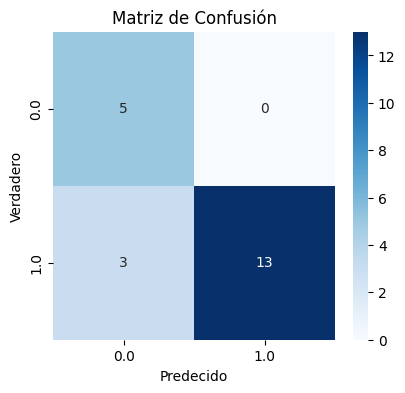

In [14]:
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predecido")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")

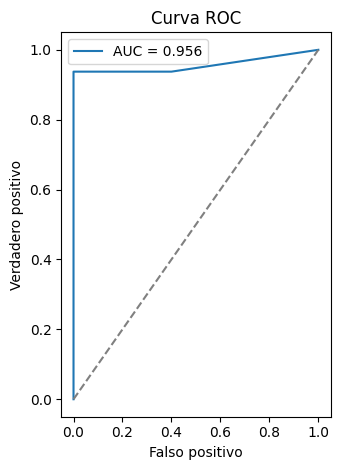

In [15]:
# ROC Curva
if len(np.unique(y)) == 2:
    plt.subplot(1, 2, 2)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("Falso positivo")
    plt.ylabel("Verdadero positivo")
    plt.title("Curva ROC")
    plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# ANÁLISIS DE FEATURES FINALES
print("\n=== FINAL FEATURE ANALYSIS ===")
best_knn = grid.best_estimator_

# Importancia según permutacion
perm_importance = permutation_importance(best_knn, X_test, y_test, 
                                        n_repeats=10, random_state=42)

perm_importance_df = pd.DataFrame({
    'feature': X_reduced.columns,
    'importancia': perm_importance.importances_mean
}).sort_values('importancia', ascending=False)

print("Top features por importancia según permutación:")
print(perm_importance_df.head(10))


=== FINAL FEATURE ANALYSIS ===
Top features por importancia según permutación:
                       feature  importancia
0                        MBI_6     0.047619
10                      MBI_11     0.038095
15             TiempoRequerido     0.033333
3                       MBI_10     0.028571
19  PERMA_7_Vida_Significativa     0.028571
4                       MBI_20     0.028571
7                        MBI_1     0.028571
18                        Edad     0.019048
17      PERMA_8_Ayuda_Compañia     0.019048
13              PERMA_14_Enojo     0.014286


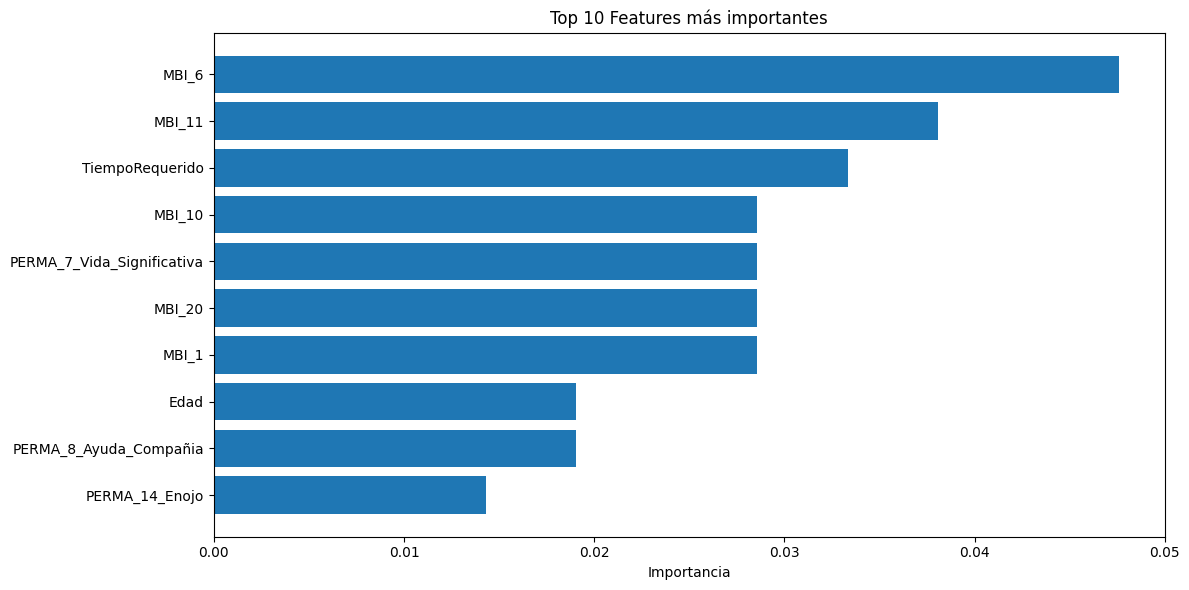

In [17]:
# VISUALIZACIÓN DE FEATURES IMPORTANTES
plt.figure(figsize=(12, 6))
top_10_features = perm_importance_df.head(10)
plt.barh(top_10_features['feature'], top_10_features['importancia'])
plt.xlabel('Importancia')
plt.title('Top 10 Features más importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [18]:
# GUARDAR MODELO Y FEATURES
import joblib

# Guardar el mejor modelo
joblib.dump(grid.best_estimator_, 'mejor_modelo_knn.pkl')

['mejor_modelo_knn.pkl']

In [19]:
# Guardar lista de features importantes
feature_importance_df = pd.DataFrame(feature_importance[:20], 
                                   columns=['feature', 'importancia'])
feature_importance_df.to_csv('features_importantes.csv', index=False)

print(f"\nModelo guardado con {len(top_features)} features")
print("Features más importantes guardados en 'features_importantes.csv'")



Modelo guardado con 20 features
Features más importantes guardados en 'features_importantes.csv'


In [20]:

# VERIFICACIÓN FINAL DE OVERFITTING
train_score = grid.score(X_train, y_train)
test_score = grid.score(X_test, y_test)

print(f"\n=== OVERFITTING CHECK ===")
print(f"Puntaje en training: {train_score:.3f}")
print(f"Puntaje en test: {test_score:.3f}")
print(f"Diferencia: {abs(train_score - test_score):.3f}")



=== OVERFITTING CHECK ===
Puntaje en training: 0.939
Puntaje en test: 0.866
Diferencia: 0.073
